## Introduction

Cassava is the second-largest provider of carbohydrates in Africa, it is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but viral diseases are major sources of poor yields.

## The dataset

The dataset contains a total of 21,397 images with specific labels for each image.
There are 5 different classes in the dataset that are available for this classification problem:
- Class 0 represents the "Cassava Bacterial Blight" and has 1087 related images
- Class 1 represents the "Cassava Brown Streak Disease" and has 2189 related images
- Class 2 represents the "Cassava Green Mottle" and has 2386 related images
- Class 3 represents the "Cassava Mosaic Disease" and has 13158 related images
- Class 4 represents the "Healthy" and has 2577 related images

An observation could be drawn that class 3 is biased and contains a number of images of more than 12 times greater than the class 0 one.

### Import usings

Import the used libraries for the project to work.

In [1]:
# Everything becomes easy and intuitive from here. 
# Also, Tez keeps your code clean and readable!
# Let's import a few things.

import os

import albumentations
import matplotlib.pyplot as plt
import pandas as pd

import tez
from tez.datasets import ImageDataset
from tez.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.nn import functional as F

import torchvision

from sklearn import metrics, model_selection, preprocessing

%matplotlib inline

### Reading the dataset

We use pandas to read the dataset from the train.csv file. The csv file contains data regarding the images in the form of a key value pair: {image id : label} - the image id being the id of the image located in the train_images folder and the label being the class in which the image is from.

We will need to obtain the values of the full paths of the images and the actual labels of each image (as targets) so we can create the dataset instance.

In [2]:
# Let's read the CSV file
dfx = pd.read_csv('C:/Users/pechd/Downloads/cassava-leaf-data/train.csv')

# and split it into training and validation sets
df_train, df_valid = model_selection.train_test_split(
    dfx, 
    test_size=0.1, 
    random_state=42,
    stratify=dfx.label.values
)

# reset index on both dataframes
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

# where are the train/valid images located?
image_path = "C:/Users/pechd/Downloads/cassava-leaf-data/train_images/"

# create a list of image paths for training
train_image_paths = [os.path.join(image_path, x) for x in df_train.image_id.values]

# create a list of image paths for validation
valid_image_paths = [os.path.join(image_path, x) for x in df_valid.image_id.values]

# targets for training
train_targets = df_train.label.values

# targets for validation
valid_targets = df_valid.label.values

In [19]:
dfx.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


## Constructing the ImageDataset

Further, we can construct the image dataset with the image paths and targets that were obtained above using the tez library, or wrapper which uses pytorch to create the dataset, tez contains a class called ImageDataset and takes as arguments the image paths, the targets and augmentations if needed (for now we won't use any).

In [3]:
# Let's create training and validation datasets
# Tez provides simple dataset class that you can use directly

# we create the train_dataset
train_dataset = ImageDataset(
    image_paths=train_image_paths,
    targets=train_targets,
    augmentations=None,
)

# and the validation dataset
valid_dataset = ImageDataset(
    image_paths=valid_image_paths,
    targets=valid_targets,
    augmentations=None,
)

In [4]:
# lets look at an item from the dataset
train_dataset[0]

{'image': tensor([[[ 44.,  43.,  39.,  ...,  67.,  68.,  66.],
          [ 46.,  46.,  47.,  ...,  63.,  68.,  71.],
          [ 52.,  53.,  54.,  ...,  50.,  61.,  67.],
          ...,
          [ 62.,  71.,  76.,  ...,  87.,  85.,  83.],
          [ 59.,  67.,  71.,  ...,  92.,  91.,  90.],
          [ 56.,  63.,  65.,  ...,  95.,  92.,  91.]],
 
         [[104., 104., 102.,  ..., 104., 102., 100.],
          [106., 108., 110.,  ..., 100., 103., 106.],
          [114., 117., 119.,  ...,  89.,  97., 103.],
          ...,
          [126., 135., 139.,  ..., 132., 129., 129.],
          [124., 132., 136.,  ..., 133., 132., 130.],
          [121., 128., 133.,  ..., 132., 131., 130.]],
 
         [[ 30.,  27.,  23.,  ...,   9.,   8.,   6.],
          [ 32.,  31.,  31.,  ...,   7.,  11.,  14.],
          [ 39.,  39.,  39.,  ...,   0.,   9.,  15.],
          ...,
          [ 42.,  51.,  58.,  ...,   5.,   5.,   4.],
          [ 40.,  48.,  54.,  ...,   5.,   4.,   5.],
          [ 37.,  44.,

We can define a method for plotting an image and observe an example from the dataset

In [5]:
def plot_image(img_dict):
    image_tensor = img_dict["image"]
    target = img_dict["targets"]
    print(target)
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0) / 255
    plt.imshow(image)

tensor(1)


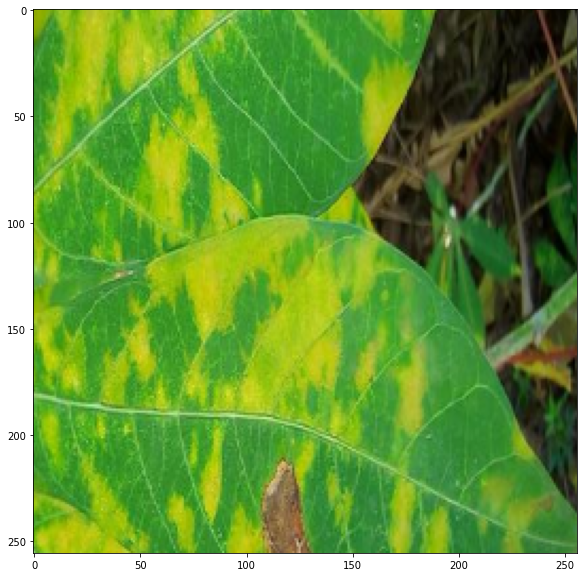

In [23]:
plot_image(train_dataset[0])

## Using augmentations

In order to improve the accuracy of the model, we can use a technique that allows us to get more data from the dataset that we already have. For this we can use augmentations - this technique is used in order to modify images so the model can be trained better (for example, cropped images, horrizontally flipped images, vertically flipped images, shifted images, transposed images, etc.)

For this purpose we can use a great library that is able to augmentate the images for us easily - it is called albumentations. Albumentations can also be used by the tez library to create the ImageDataset.

In [24]:
# Now, lets add some augmentations using one of the best
# augmentations library: albumentations
# Tez supports albumentations exclusively

train_aug = albumentations.Compose(
    [
        albumentations.RandomResizedCrop(256, 256),
        albumentations.Transpose(p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.VerticalFlip(p=0.5),
        albumentations.ShiftScaleRotate(p=0.5)
    ]
)

# we can now recreate the ImageDataset and also specify the augmentations for the images
train_dataset = ImageDataset(
    image_paths=train_image_paths,
    targets=train_targets,
    augmentations=train_aug,
)

tensor(1)


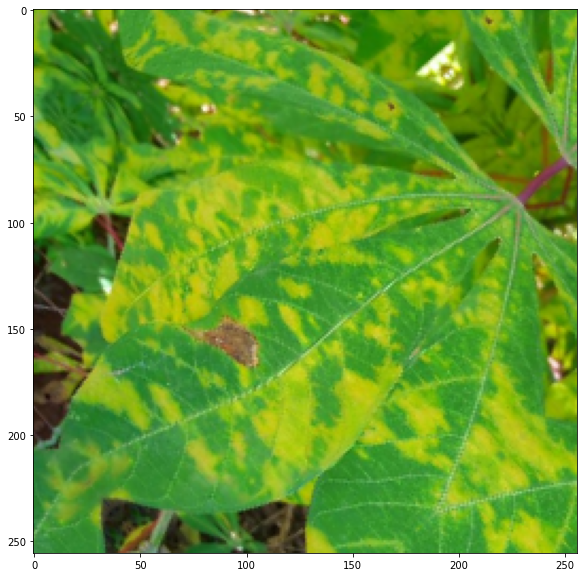

In [26]:
# we can look at an augmentated image (a vertically flipped one)
plot_image(train_dataset[0])

## Defining the Model

We will create the class of the model based on the tez.Model class, which in turn inherits from torch.nn.Module. The tez.Model class is a wrapper on the nn.Module class.

#### Using Resnet
The model is constructed using resnet18 from the torchvision models with an output layer that is linear, which takes as input 512 values and outputs 5 values, which are the number of classes of this multi-class classification.

#### Functions
We will define the forward function which will take two parameters (image and targets) and it will return a tuple of three (the outputs, the loss, and the metrics, which in this case is accuracy).

The fetch_optimizer function is also defined which returns the scheduler, in our case the step of the scheduler is executed after each epoch.

The monitor_metrics function takes as parameters the outputs and targets and it returns the accuracy score of the model based on the parameters.

In [9]:
# Let's define a model now
# We inherit from tez.Model instead of nn.Module
# we have monitor_metrics if we want to monitor any metrics
# except the loss
# and we return 3 values in the forward function.

class LeafModel(tez.Model):
    def __init__(self, num_classes):
        super().__init__()

        self.convnet = torchvision.models.resnet18(pretrained=True)
        self.convnet.fc = nn.Linear(512, num_classes)
        self.step_scheduler_after = "epoch"
        
    def monitor_metrics(self, outputs, targets):
        if targets is None:
            return {}
        outputs = torch.argmax(outputs, dim=1).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, outputs)
        return {"accuracy": accuracy}
    
    def fetch_optimizer(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        return opt
    
    def fetch_scheduler(self):
        sch = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=0.7)
        return sch

    def forward(self, image, targets=None):
        batch_size, _, _, _ = image.shape

        outputs = self.convnet(image)
        
        if targets is not None:
            loss = nn.CrossEntropyLoss()(outputs, targets)
            metrics = self.monitor_metrics(outputs, targets)
            return outputs, loss, metrics
        return outputs, None, None

In [12]:
# we create the model as LeafModel with the number of classes being 5
model = LeafModel(num_classes=5)

In [14]:
# preview of the index 0 tensors from te model
image = train_dataset[0]["image"].unsqueeze(0)
target = train_dataset[0]["targets"].unsqueeze(0)


model(image, target)

(tensor([[ 0.2526, -0.2286, -0.0526, -0.1833,  0.6161]],
        grad_fn=<AddmmBackward>),
 tensor(1.9719, grad_fn=<NllLossBackward>),
 {'accuracy': 0.0})

In [27]:
model

LeafModel(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

## Prepare augmented datasets

Prepare the augmentations for the training and validation datasets using albumentations (with multiple augmentations), then create the ImageDatasets for the train and validation datasets using tez.

In [28]:
# prepare training augmentations for the training dataset
train_aug = albumentations.Compose([
            albumentations.RandomResizedCrop(256, 256),
            albumentations.Transpose(p=0.5),
            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            albumentations.ShiftScaleRotate(p=0.5),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            )], p=1.)

# prepare validation augmentations for the validation dataset
valid_aug = albumentations.Compose([
            albumentations.CenterCrop(256, 256, p=1.),
            albumentations.Resize(256, 256),
            albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            )], p=1.)

# create the training dataset including the training data augmentations augmentations
train_dataset = ImageDataset(
    image_paths=train_image_paths,
    targets=train_targets,
    augmentations=train_aug,
)

# create the validation dataset including the validation data augmentations
valid_dataset = ImageDataset(
    image_paths=valid_image_paths,
    targets=valid_targets,
    augmentations=valid_aug,
)

## Train the model

Start the training of the model using the train and validation datasets on a model that is resnet18 based and has as output layer a Linear layer with 5 possible outputs.

In [18]:
# set an early stopping of the model training
es = EarlyStopping(
    monitor="valid_accuracy", model_path="model.bin", patience=2, mode="max"
)

#start training the model for the datasets using the resnet18 approach
model.fit(
    train_dataset,
    valid_dataset=valid_dataset,
    train_bs=32,
    valid_bs=64,
    device="cpu",
    epochs=5,
    callbacks=[es],
    fp16=True,
)

C:\Users\pechd\mini_conda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
  0%|                                                                                          | 0/602 [00:00<?, ?it/s]C:\Users\pechd\mini_conda3\lib\site-packages\torch\cuda\amp\autocast_mode.py:114: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")
100%|█████████████████████████████████████████| 34/34 [02:14<00:00,  3.96s/it, accuracy=0.681, loss=0.828, stage=valid]


Validation score improved (-inf --> 0.6811318277310924). Saving model!


100%|█████████████████████████████████████████| 34/34 [02:10<00:00,  3.83s/it, accuracy=0.683, loss=0.784, stage=valid]


Validation score improved (0.6811318277310924 --> 0.6834296218487395). Saving model!


  0%|                                                                                          | 0/602 [00:00<?, ?it/s]

Validation score improved (0.6834296218487395 --> 0.7459952731092436). Saving model!


100%|███████████████████████████████████████████| 34/34 [02:33<00:00,  4.51s/it, accuracy=0.755, loss=0.7, stage=valid]


Validation score improved (0.7459952731092436 --> 0.7553177521008404). Saving model!


100%|█████████████████████████████████████████| 34/34 [02:17<00:00,  4.03s/it, accuracy=0.758, loss=0.665, stage=valid]


Validation score improved (0.7553177521008404 --> 0.7577468487394958). Saving model!
